In [1]:
import pandas as pd
import spacy
import emoji
import re
nlp = spacy.load('en_core_web_sm')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.lines import Line2D

Emotion classifier used for this analysis: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base?text=Yes%21%21%21%21%21+I+didn%27t+know+that 

In [2]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, truncation=True)
# Example output
classifier("I love this!")

C:\Users\lucak\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'anger', 'score': 0.004419791977852583},
  {'label': 'disgust', 'score': 0.0016119939973577857},
  {'label': 'fear', 'score': 0.0004138525982853025},
  {'label': 'joy', 'score': 0.9771687984466553},
  {'label': 'neutral', 'score': 0.005764594301581383},
  {'label': 'sadness', 'score': 0.002092393347993493},
  {'label': 'surprise', 'score': 0.008528684265911579}]]

In [3]:
df = pd.read_csv("RedditSubmissionsClean.csv").drop(columns='Unnamed: 0')

In [4]:
df.head(2)

,upvotes,date,title,username,subreddit,text,post_id
0,43,2023-07-01,Will Israel still be habitable in the decades ...,u/TransThrowaway4096,r/Israel,"One of my dreams to make Aliyah, but as as the...",14ngcep
1,28,2023-07-01,What am I? I feel like an imposter.,u/Iamthe_slime,r/Jewish,Idrk what I expect from this but I feel like I...,14nwxg7


# Cleaning & Classifying

In [6]:
def clean(text):
    text = ' '.join([token.lemma_ # keep the base form
            for token in nlp(text)]) # after splitting the sentence into words
    text = text.lower()
    text = emoji.demojize(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text[:480]

df = df.copy()
df.loc[: ,'text_cleaned'] = df.text.apply(clean)


KeyboardInterrupt



In [8]:
df = df.copy()

df.loc[:,"emotions"] = df['text_cleaned'].apply(lambda x: classifier(x))

In [ ]:
df.loc[:,"anger"] = df["emotions"].apply(lambda x: x[0][0]["score"])
df.loc[:,"disgust"] = df["emotions"].apply(lambda x: x[0][1]["score"])
df.loc[:,"fear"] = df["emotions"].apply(lambda x: x[0][2]["score"])
df.loc[:,"joy"] = df["emotions"].apply(lambda x: x[0][3]["score"])
df.loc[:,"neutral"] = df["emotions"].apply(lambda x: x[0][4]["score"])
df.loc[:,"sadness"] = df["emotions"].apply(lambda x: x[0][5]["score"])
df.loc[:,"surprise"] = df["emotions"].apply(lambda x: x[0][6]["score"])

In [20]:
# Saving the df to avoid recomputing
#df.to_csv('df_emotions.csv', index=False)

# How do emotions in the posts evolve through time?

In [5]:
df = pd.read_csv('df_emotions.csv')
df['date'] = pd.to_datetime(df['date'])

In [6]:
df["resentment"] = df["anger"] + df["sadness"] 

In [7]:
df_israel = df[df.subreddit == "r/Israel"]
df_palestine = df[df.subreddit == "r/Palestine"]
df_ip = df[df.subreddit == "r/IsraelPalestine"]
df = df[df.subreddit.isin(["r/Israel","r/Palestine", "r/IsraelPalestine"])]
print(df.shape, df_israel.shape, df_palestine.shape, df_ip.shape)

(14039, 17) (5960, 17) (1412, 17) (6667, 17)


In [8]:
df_pre = df[df['date'] < "2023-08-07"]
df_post = df[df['date'] >= "2023-08-07"]

In [9]:
print(df["disgust"].mean() , df["neutral"].mean())

0.013710985889282013 0.05260208170892682


In [11]:
print(len(df_pre), len(df_post))
print("neutral pre:",df_pre["neutral"].mean(), "\tneutral post:", df_post["neutral"].mean())

795 13244
neutral pre: 0.07665877792934456 	neutral post: 0.05115802602369335


In [12]:
import scipy.stats as stats

# Assuming df_pre and df_post are already defined as pandas DataFrames
t_stat, p_value = stats.ttest_ind(df_pre["neutral"], df_post["neutral"], equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < 0.001:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")


t-statistic: 5.726023860880984
p-value: 1.4290197105206764e-08
The difference in means is statistically significant.


In [13]:
print("disgust pre:",df_pre["disgust"].mean(), "\tdisgust post:", df_post["disgust"].mean())
print("surprise pre:",df_pre["surprise"].mean(), "\tsurprise post:", df_post["surprise"].mean())
print("neutral pre:",df_pre["neutral"].mean(), "\tneutral post:", df_post["neutral"].mean())

disgust pre: 0.014603091994686294 	disgust post: 0.013657435273622362
surprise pre: 0.11499504735971557 	surprise post: 0.09507620191003419
neutral pre: 0.07665877792934456 	neutral post: 0.05115802602369335


In [15]:
# Group by date and calculate the mean for each emotion
emotions = ['resentment', 'joy', 'fear']

List of events extracted from: https://www.washingtonpost.com/world/2024/04/07/israel-hamas-gaza-war-timeline-anniversary/ and https://www.reuters.com/world/middle-east/major-events-during-war-gaza-2024-02-27/

In [16]:
conflict_escalation = [   
    (datetime(2023, 10, 7), "Hamas launches deadly attack on Israel"),
    (datetime(2023, 10, 17), "At least 100 people killed in last at al-Ahli Hospital"), 
    (datetime(2023, 10, 31), "Israeli strikes on Jabalya kill more than 100 people"),
    (datetime(2023, 12, 3), "Israel announced expansion of ground assault to southern Gaza"),
    (datetime(2024, 2, 29), "100 Gazans are killed queuing for aid"),
    (datetime(2024, 4, 1), "Seven aid workers killed in air strike and Iran's embassy hit in Syria")
]

In [17]:
conflict_resolution = [
    (datetime(2023, 11, 24), "Israel, Hamas pause fighting in hostages-for-prisoners deal"),
    (datetime(2024, 1, 2), "Senior Hamas leader killed in blast in Beirut"),
    (datetime(2024, 1, 26), "ICJ heard case against Israel, acknowledged potential genocide violations")
]

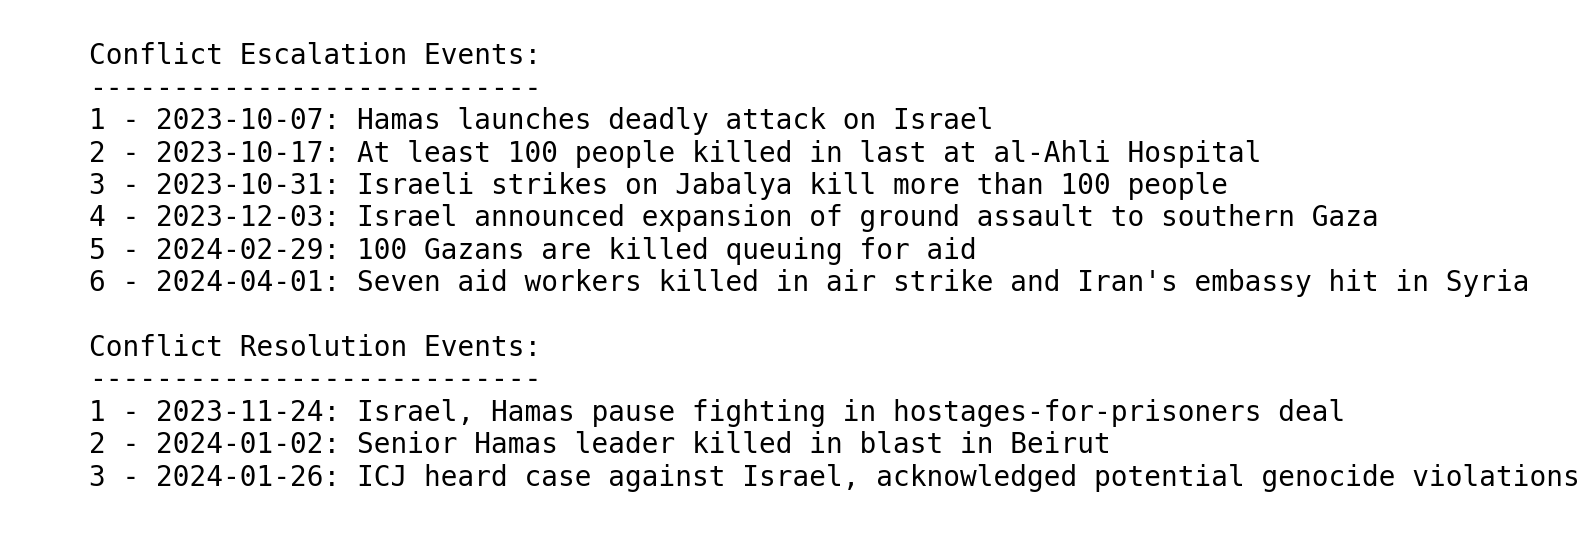

In [18]:
# Create a text representation
text = """
Conflict Escalation Events:
---------------------------
"""

for index, (date, description) in enumerate(conflict_escalation, start=1):
    text += f"{index} - {date.strftime('%Y-%m-%d')}: {description}\n"

text += """
Conflict Resolution Events:
---------------------------
"""

for index, (date, description) in enumerate(conflict_resolution, start=1):
    text += f"{index} - {date.strftime('%Y-%m-%d')}: {description}\n"

# Plot
plt.figure(figsize=(16, 5))
plt.text(1, 1, text, ha='left', va='top', fontsize=20, family='monospace')
plt.axis('off')  # Turn off axes
plt.tight_layout()
plt.savefig('conflict_events.png')
plt.show()


In [19]:
text

"\nConflict Escalation Events:\n---------------------------\n1 - 2023-10-07: Hamas launches deadly attack on Israel\n2 - 2023-10-17: At least 100 people killed in last at al-Ahli Hospital\n3 - 2023-10-31: Israeli strikes on Jabalya kill more than 100 people\n4 - 2023-12-03: Israel announced expansion of ground assault to southern Gaza\n5 - 2024-02-29: 100 Gazans are killed queuing for aid\n6 - 2024-04-01: Seven aid workers killed in air strike and Iran's embassy hit in Syria\n\nConflict Resolution Events:\n---------------------------\n1 - 2023-11-24: Israel, Hamas pause fighting in hostages-for-prisoners deal\n2 - 2024-01-02: Senior Hamas leader killed in blast in Beirut\n3 - 2024-01-26: ICJ heard case against Israel, acknowledged potential genocide violations\n"

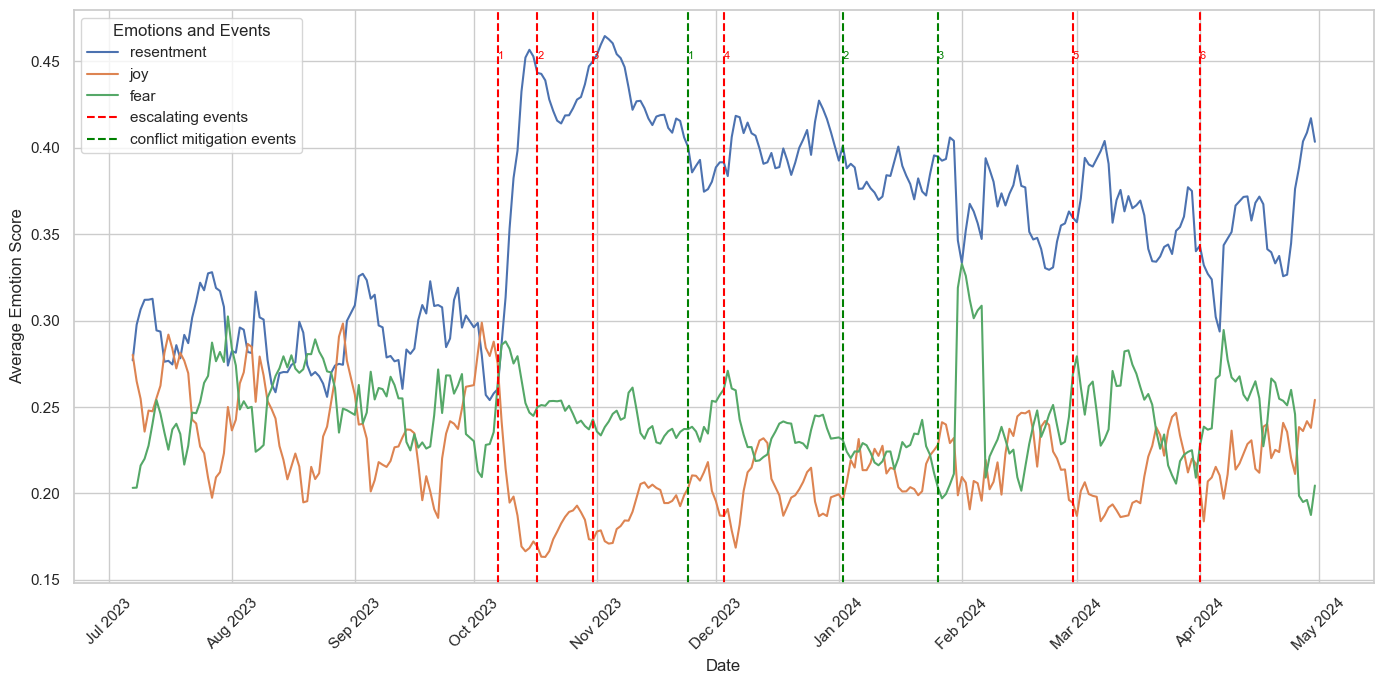

In [20]:
# Daily mean for each emotion
daily_means = df.groupby('date')[emotions].mean().reset_index()

# Calculate the 3-day rolling average for each emotion
rolling_means = daily_means.set_index('date').rolling(window=7).mean().reset_index()

# Plot the results
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for emotion in emotions:
    sns.lineplot(data=rolling_means, x='date', y=emotion, label=emotion)

ax = plt.gca()

# Add vertical lines and numbers for the events
for i, (event_date, _) in enumerate(conflict_escalation, start=1):
    ax.axvline(x=event_date, color='red', linestyle='--', label='escalating events' if i == 1 else "")
    ax.text(event_date, ax.get_ylim()[1] * 0.95, str(i), rotation=0, verticalalignment='top', fontsize=8, color='red')

for i, (event_date, _) in enumerate(conflict_resolution, start=1):
    ax.axvline(x=event_date, color='green', linestyle='--', label='conflict mitigation events' if i == 1 else "")
    ax.text(event_date, ax.get_ylim()[1] * 0.95, str(i), rotation=0, verticalalignment='top', fontsize=8, color='green')


# Add custom legend elements
legend_elements = [
    Line2D([0], [0], color='red', lw=2, linestyle='--'),
    Line2D([0], [0], color='green', lw=2, linestyle='--'),
]

# Add the custom legend for event types
ax.legend(handles=legend_elements, title="Event Types", loc='upper right')

#plt.title('7-Day Rolling Average of Emotions for all subreddits')
plt.xlabel('Date')
plt.ylabel('Average Emotion Score')
plt.legend(title='Emotions and Events', loc='upper left')

# Format the x-axis to show month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


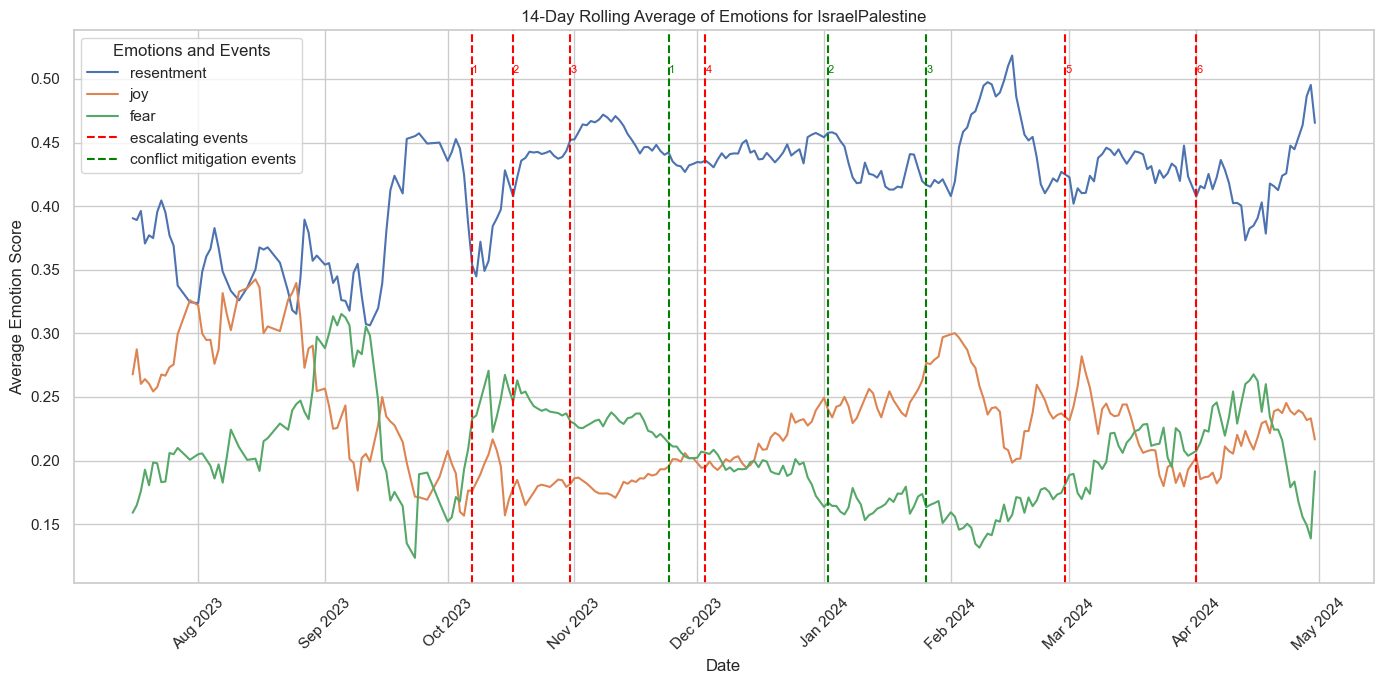

In [21]:
# Daily mean for each emotion
daily_means = df_ip.groupby('date')[emotions].mean().reset_index()

# Calculate the 3-day rolling average for each emotion
rolling_means = daily_means.set_index('date').rolling(window=14).mean().reset_index()

# Plot the results
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for emotion in emotions:
    sns.lineplot(data=rolling_means, x='date', y=emotion, label=emotion)

ax = plt.gca()

# Add vertical lines and numbers for the events
for i, (event_date, _) in enumerate(conflict_escalation, start=1):
    ax.axvline(x=event_date, color='red', linestyle='--', label='escalating events'  if i == 1 else "")
    ax.text(event_date, ax.get_ylim()[1] * 0.95, str(i), rotation=0, verticalalignment='top', fontsize=8, color='red')

for i, (event_date, _) in enumerate(conflict_resolution, start=1):
    ax.axvline(x=event_date, color='green', linestyle='--', label='conflict mitigation events'  if i == 1 else "")
    ax.text(event_date, ax.get_ylim()[1] * 0.95, str(i), rotation=0, verticalalignment='top', fontsize=8, color='green')


plt.title('14-Day Rolling Average of Emotions for IsraelPalestine')
plt.xlabel('Date')
plt.ylabel('Average Emotion Score')
plt.legend(title='Emotions and Events', loc='upper left')

# Format the x-axis to show month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


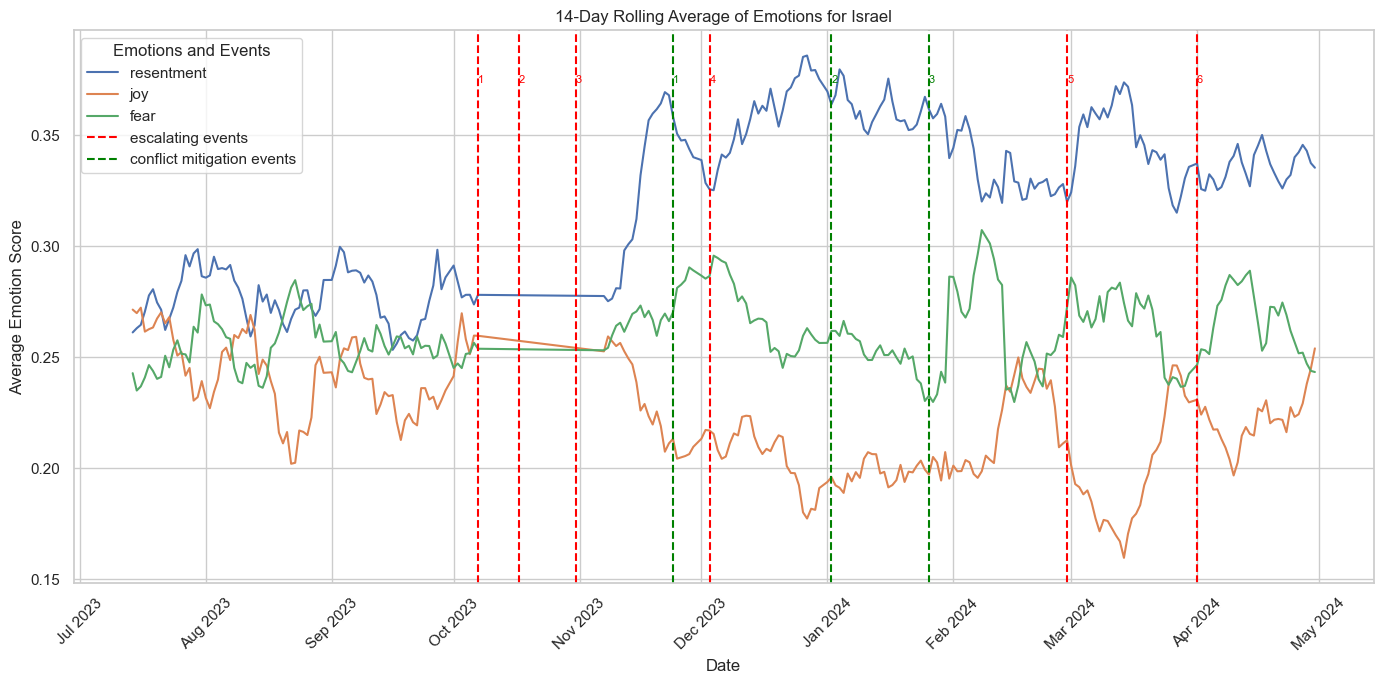

In [22]:
# Daily mean for each emotion
daily_means = df_israel.groupby('date')[emotions].mean().reset_index()

# Calculate the 3-day rolling average for each emotion
rolling_means = daily_means.set_index('date').rolling(window=14).mean().reset_index()

# Plot the results
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for emotion in emotions:
    sns.lineplot(data=rolling_means, x='date', y=emotion, label=emotion)

ax = plt.gca()

# Add vertical lines and numbers for the events
for i, (event_date, _) in enumerate(conflict_escalation, start=1):
    ax.axvline(x=event_date, color='red', linestyle='--', label='escalating events'  if i == 1 else "")
    ax.text(event_date, ax.get_ylim()[1] * 0.95, str(i), rotation=0, verticalalignment='top', fontsize=8, color='red')

for i, (event_date, _) in enumerate(conflict_resolution, start=1):
    ax.axvline(x=event_date, color='green', linestyle='--', label='conflict mitigation events'  if i == 1 else "")
    ax.text(event_date, ax.get_ylim()[1] * 0.95, str(i), rotation=0, verticalalignment='top', fontsize=8, color='green')


    
plt.title('14-Day Rolling Average of Emotions for Israel')
plt.xlabel('Date')
plt.ylabel('Average Emotion Score')
plt.legend(title='Emotions and Events', loc='upper left')

# Format the x-axis to show month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


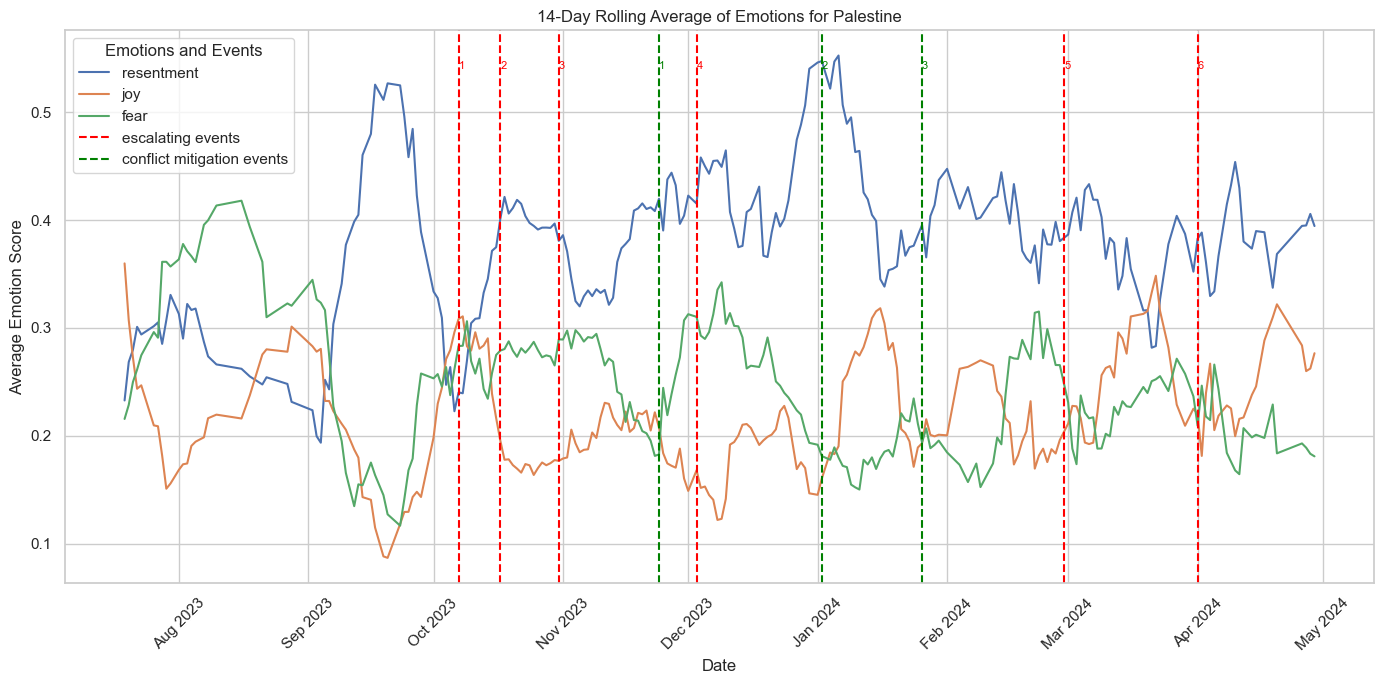

In [23]:
# Daily mean for each emotion
daily_means = df_palestine.groupby('date')[emotions].mean().reset_index()

# Calculate the 3-day rolling average for each emotion
rolling_means = daily_means.set_index('date').rolling(window=14).mean().reset_index()

# Plot the results
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for emotion in emotions:
    sns.lineplot(data=rolling_means, x='date', y=emotion, label=emotion)

ax = plt.gca()

# Add vertical lines and numbers for the events
for i, (event_date, _) in enumerate(conflict_escalation, start=1):
    ax.axvline(x=event_date, color='red', linestyle='--', label='escalating events' if i == 1 else "")
    ax.text(event_date, ax.get_ylim()[1] * 0.95, str(i), rotation=0, verticalalignment='top', fontsize=8, color='red')

for i, (event_date, _) in enumerate(conflict_resolution, start=1):
    ax.axvline(x=event_date, color='green', linestyle='--', label='conflict mitigation events' if i == 1 else "")
    ax.text(event_date, ax.get_ylim()[1] * 0.95, str(i), rotation=0, verticalalignment='top', fontsize=8, color='green')

plt.title('14-Day Rolling Average of Emotions for Palestine')
plt.xlabel('Date')
plt.ylabel('Average Emotion Score')
plt.legend(title='Emotions and Events', loc='upper left')

# Format the x-axis to show month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
